# Generate SFigures: Dislocations

In [1]:
import scipy.ndimage as ndi
from skimage.transform import rotate, rescale
from skimage.registration import phase_cross_correlation
from skimage.io import imread
import os
import numpy as np
import matplotlib.pyplot as plt
import colorcet

import latticegen
from latticegen.transformations import epsilon_to_kappa, a_0_to_r_k, r_k_to_a_0
from latticegen import physical_lattice_gen
import pyGPA.geometric_phase_analysis as GPA
import pyGPA.property_extract as pe
from pyGPA.imagetools import gauss_homogenize2

## Additional dislocations

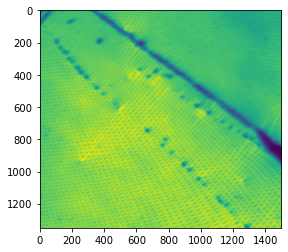

In [2]:
folder = "data"
name = "20200715_154404_0.66um_495.9_sweep-STAGE_X-STAGE_Y_highres_highE_stitch_v10_2020-11-20_1843_sobel_5_bw_200.tif"
NMPERPIXEL = 0.88

oimage = imread(os.path.join(folder, name)).squeeze()[2700:4200, 1850:3200].astype(np.float64)
plt.imshow(oimage.T)

closest triangle: [[ 0.03333333  0.03      ]
 [ 0.03666667 -0.02666667]
 [ 0.02        0.02      ]
 [-0.          0.05333333]]
pks [[ 0.03333333  0.03      ]
 [ 0.03666667 -0.02666667]
 [-0.          0.05333333]]
pks [[ 0.03        0.02666667]
 [ 0.02333333 -0.02333333]
 [ 0.00666667  0.05      ]]
pks [[ 0.00333333  0.04333333]
 [ 0.03666667  0.03      ]
 [ 0.03333333 -0.01333333]]


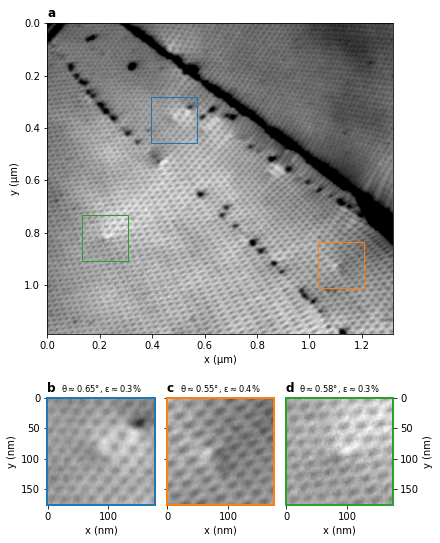

In [3]:
layout = """
    aaa
    bcd
"""

fig = plt.figure(figsize=[6, 7.7], constrained_layout=True)
axs = fig.subplot_mosaic(layout,
                         gridspec_kw={"height_ratios": [3, 1],
                                      # "width_ratios": [4, 1],
                                      })

kwargs = dict(alpha=0.5)
ikwargs = dict(cmap='gray', vmax=np.quantile(oimage, 1-1e-6),
               vmin=np.quantile(oimage, 0.03), interpolation='none')
im = axs['a'].imshow(oimage.T, **ikwargs)
# im.set_extent(np.array(im.get_extent())*NMPERPIXEL/1e3)
axs['a'].set_ylabel('y (μm)')
axs['a'].set_xlabel('x (μm)')

coords = np.array([[550, 420],
                  [1275, 1050],
                  [250, 930]])
axi = [axs[l] for l in 'bcd']
dr = 150
dr2 = 100
for i, coord in enumerate(coords):
    #axs['a'].scatter(*(coord*NMPERPIXEL/1e3), **kwargs)
    rect = plt.Rectangle((coord-dr2)*NMPERPIXEL/1e3,
                         dr2*2*NMPERPIXEL/1e3,
                         dr2*2*NMPERPIXEL/1e3,
                         edgecolor=f'C{i}',
                         fill=False, alpha=0.99, lw=1,
                         #path_effects=[patheffects.withStroke(linewidth=2, foreground="white", alpha=0.3)]
                         )
    axs['a'].add_artist(rect)
    lim = oimage[coord[0]-dr:coord[0]+dr,
                 coord[1]-dr:coord[1]+dr]
    lim2 = oimage[coord[0]-dr2:coord[0]+dr2,
                  coord[1]-dr2:coord[1]+dr2]
    im2 = axi[i].imshow(lim2.T, **ikwargs)
    im2.set_extent(np.array(im2.get_extent())*NMPERPIXEL)

    axi[i].set_xlabel('x (nm)')
    pks, _ = GPA.extract_primary_ks(lim - lim.mean(), pix_norm_range=(4, 50))
    print("pks", pks)
    props = pe.Kerelsky_plus(pks, nmperpixel=NMPERPIXEL, sort=1)
    axi[i].set_title(f"$\\theta \\approx ${props[0]:.2f}°, $\\epsilon \\approx ${props[2]*100:.1f}%",
                     fontsize='small')
    for axis in ['top', 'bottom', 'left', 'right']:
        axi[i].spines[axis].set_linewidth(2)
        axi[i].spines[axis].set_color(f'C{i}')
axi[1].tick_params(axis='y', which='both', labelleft=False, labelright=False)
axi[2].tick_params(axis='y', which='both', labelleft=False, labelright=True)
axi[2].yaxis.tick_right()
axi[2].yaxis.set_label_position("right")
axi[0].set_ylabel('y (nm)')
axi[2].set_ylabel('y (nm)')
im.set_extent(np.array(im.get_extent())*NMPERPIXEL/1e3)
for key in axs.keys():
    axs[key].set_title(key, loc='left', fontweight='bold')
plt.savefig(os.path.join('figures', 'SI_dislocations.pdf'))

## Overlay

In [4]:
name2 = "20200713_163811_5.7um_501.2_sweep-STAGE_X-STAGE_Y_domainboundaries_stitch_v10_2020-11-20_1649_sobel_4_bw_200.tif"

r1 = 1500
r2 = 500
c0 = [3200, 3000]
c1 = [4075, 6900]
image1 = imread(os.path.join(folder, name)).squeeze()[c0[0]-r1:c0[0]+r1, c0[1]-r1:c0[1]+r1].astype(np.float64)
image2 = imread(os.path.join(folder, name2)).squeeze()[c1[0]-r2:c1[0]+r2, c1[1]-r2:c1[1]+r2].astype(np.float64)

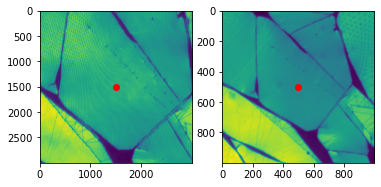

In [5]:
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(image1[::-1, ::-1])
axs[0].scatter(r1, r1, color='red')
axs[1].imshow(image2)
axs[1].scatter(r2, r2, color='red')

In [6]:
scaling = 0.88/3.7 * 0.999
scaling

0.23759999999999998

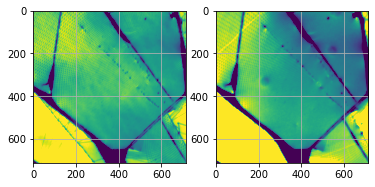

In [7]:
fig, axs = plt.subplots(ncols=2)
scaled = rescale(image1[::-1, ::-1], scaling)

rotated = rotate(image2, -10+0.9+0.45, resize=True)
r1s = scaled.shape[0]//2
center = np.array(rotated.shape)//2
rcropped = rotated[center[0]-r1s:center[0]+r1s+scaled.shape[0] % 2,
                   center[1]-r1s:center[1]+r1s+scaled.shape[0] % 2]
im = axs[0].imshow(scaled, vmax=np.quantile(scaled, 0.9), vmin=np.quantile(scaled, 0.05))

im = axs[1].imshow(rcropped, vmax=np.quantile(rcropped, 0.85), vmin=np.quantile(rcropped, 0.07))
for ax in axs:
    ax.grid()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


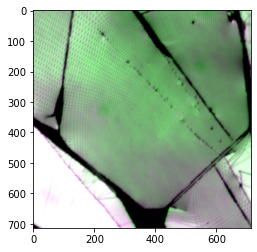

In [8]:
plt.figure()
green = scaled
purple = rcropped
normed_green = green - np.quantile(green, 0.05)
normed_green /= np.quantile(normed_green, 0.9)
norm_purple = purple - np.quantile(purple, 0.05)
norm_purple /= np.quantile(norm_purple, 0.9)
plt.imshow(np.stack([norm_purple,
                     normed_green,
                     norm_purple,
                     ], axis=-1))

In [9]:
shifts = [0, 0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


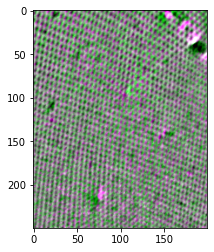

In [10]:
plt.figure()
green = scaled[320:570, 300:500].copy()
purple = rcropped[320:570, 300:500].copy()
purple = ndi.shift(purple, shifts, mode='reflect')
green = gauss_homogenize2(green, sigma=6, mask=np.ones_like(green))
purple = gauss_homogenize2(purple, sigma=6, mask=np.ones_like(purple))
norm_green = green - np.quantile(green, 0.001)
norm_green /= np.quantile(norm_green, 0.999)
norm_purple = purple - np.quantile(purple, 0.005)
norm_purple /= np.quantile(norm_purple, 0.995)
plt.imshow(np.stack([norm_purple,
                     norm_green,
                     norm_purple,
                     ], axis=-1))

In [11]:
shifts, error, phasediff = phase_cross_correlation(green-green.mean(),
                                                   purple-purple.mean(),
                                                   upsample_factor=100)
shifts, error

(array([-0.12, -1.11]), 0.9474278784345549)

closest triangle: [[ 0.024  0.2  ]
 [ 0.168  0.145]
 [ 0.156  0.145]
 [ 0.148 -0.055]
 [ 0.144  0.13 ]
 [ 0.128 -0.055]]
0.6259268669329141 235.75743840118824 0.0038138233573922803 85.18887904688606


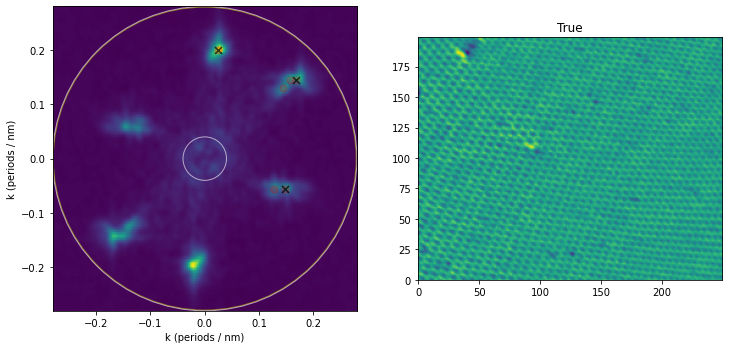

In [12]:
kvecs, _ = GPA.extract_primary_ks(green, plot=True, pix_norm_range=(10, 70), threshold=0.3)
theta, psi, epsilon, xi = pe.Kerelsky_plus(kvecs, nmperpixel=NMPERPIXEL / scaling, sort=1)
print(theta, xi, epsilon, psi)

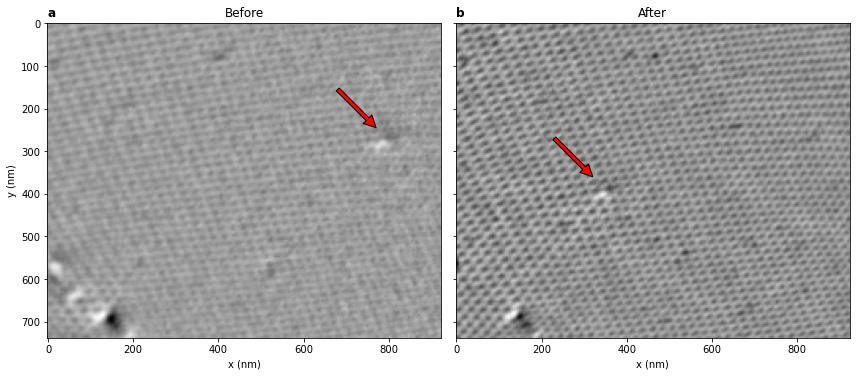

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=[12, 5.1], sharex=True, sharey=True)
im = axs[0].imshow(purple.T, cmap='gray')
im.set_extent(np.array(im.get_extent()) * 3.7)
im = axs[1].imshow(green.T, cmap='gray', )
im.set_extent(np.array(im.get_extent()) * 3.7)

axs[0].set_title('Before')
axs[1].set_title('After')
for ax in axs:
    ax.set_xlabel('x (nm)')
axs[0].set_ylabel('y (nm)')

axs[0].annotate('', (800, 275), (800-150, 275-150),
                arrowprops=dict(facecolor='red', shrink=0.2),
                horizontalalignment='left', verticalalignment='bottom',)
axs[1].annotate('', (350, 390), (350-150, 390-150),
                arrowprops=dict(facecolor='red', shrink=0.2),
                horizontalalignment='left', verticalalignment='bottom',)

for ax, label in zip(axs, 'ab'):
    ax.set_title(label, loc='left', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join('figures', 'SI_movement_top.pdf'))

In [14]:
S = 2000
pixelspernm = scaling/NMPERPIXEL*100
l1 = physical_lattice_gen(0.246, xi,
                          2,
                          pixelspernm=pixelspernm, size=S).compute()
l1 = l1-l1.min()
r_k2, kappa2 = epsilon_to_kappa(a_0_to_r_k(0.246), epsilon)
ks1 = latticegen.generate_ks(a_0_to_r_k(0.246), xi, kappa=1)
ks2 = latticegen.generate_ks(r_k2, xi+theta, kappa=kappa2, psi=psi)

l2 = physical_lattice_gen(r_k_to_a_0(r_k2), xi+theta,
                          2,
                          pixelspernm=pixelspernm, kappa=kappa2, psi=psi, size=S).compute()
l2 = l2-l2.min()
gauss_sigma = 3
moire = ndi.gaussian_filter(np.sqrt(l1*l1+l2*l2), gauss_sigma)[2*gauss_sigma:-2*gauss_sigma,
                                                               2*gauss_sigma:-2*gauss_sigma]

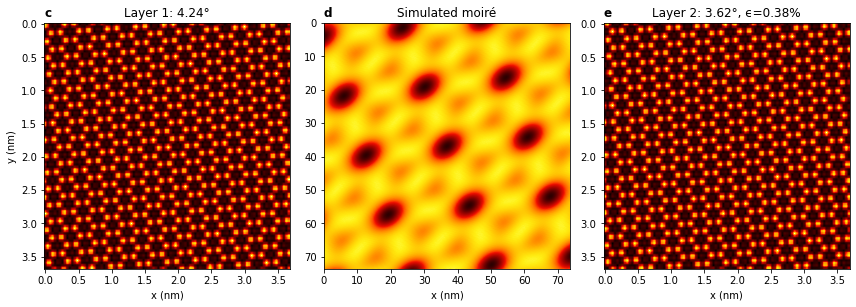

In [15]:
f, axs = plt.subplots(ncols=3, figsize=[12, 4.2])
r = 950
im = axs[0].imshow(l1[r:-r, r:-r].T, cmap='cet_fire')
im.set_extent(np.array(im.get_extent()) / pixelspernm)
im = axs[1].imshow(moire.T, cmap='cet_fire')
im.set_extent(np.array(im.get_extent()) / pixelspernm)
im = axs[2].imshow(l2[r:-r, r:-r].T, cmap='cet_fire')
im.set_extent(np.array(im.get_extent()) / pixelspernm)
axs[0].set_title(f'Layer 1: {-xi %60:.2f}°')
axs[1].set_title('Simulated moiré')
axs[2].set_title(f'Layer 2: {(-theta-xi) %60:.2f}°, ϵ={epsilon*100:.2f}%')
for ax in axs:
    ax.set_xlabel('x (nm)')
axs[0].set_ylabel('y (nm)')
for ax, label in zip(axs, 'cde'):
    ax.set_title(label, loc='left', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join('figures', 'SI_movement_bottom.pdf'))